In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy
import tensorflow as tf

from sklearn import ensemble
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

from tensorflow.keras.utils import to_categorical
from keras import models
from keras import layers
from keras import saving

from datetime import datetime
import pickle
import warnings
from time import time

warnings.filterwarnings("ignore")

In [1]:
%%capture
!wget https://www.dropbox.com/scl/fi/rz8xmydm1h3bpgjjm30jd/bank_train.csv
!wget https://www.dropbox.com/scl/fi/05p2v6pw76tjf7c21rcyb/bank_valid.csv

In [2]:
df = pd.read_csv('friance new.csv', encoding='iso-8859-1')
train_df = pd.read_csv('bank_train.csv', encoding='iso-8859-1')
valid_df = pd.read_csv('bank_valid.csv', encoding='iso-8859-1')
train_df.isnull().any()

Number                False
Surname               False
CreditScore           False
Age                   False
Tenure                False
Balance               False
NumOfProducts         False
HasCrCard             False
IsActiveMember        False
EstimatedSalary       False
Exited                False
Surname_tfidf_0       False
Surname_tfidf_1       False
Surname_tfidf_2       False
Surname_tfidf_3       False
Surname_tfidf_4       False
France                False
Germany               False
Spain                 False
Female                False
Male                  False
Mem__no__Products     False
Cred_Bal_Sal          False
Bal_sal               False
Tenure_Age            False
Age_Tenure_product    False
dtype: bool

In [52]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Surname,175028.0,1617.462812,813.852174,0.0,949.0,1666.0,2292.00,2931.00
CreditScore,175028.0,656.113068,81.148273,350.0,597.0,659.0,710.00,850.00
Age,175028.0,38.171337,8.969565,18.0,32.0,37.0,42.00,92.00
Tenure,175028.0,5.019968,2.811155,0.0,3.0,5.0,7.00,10.00
Balance,175028.0,56676.772103,62982.418525,0.0,0.0,0.0,120727.97,250898.09
NumOfProducts,175028.0,1.553072,0.549212,1.0,1.0,2.0,2.00,4.00
HasCrCard,175028.0,0.751183,0.432329,0.0,1.0,1.0,1.00,1.00
IsActiveMember,175028.0,0.498754,0.500000,0.0,0.0,0.0,1.00,1.00
Exited,175028.0,0.211149,0.408125,0.0,0.0,0.0,0.00,1.00
France,175028.0,0.566909,0.495504,0.0,0.0,1.0,1.00,1.00


In [15]:
train_df.groupby(['Exited', 'Cred_Bal_Sal']).count()

Surname  CreditScore    Age  Tenure  Balance  \
Exited Cred_Bal_Sal                                                             
0      0.0                         78272        78272  78272   78272    78272   
       1.000.202.391.880.190,00        1            1      1       1        1   
       1.000.400.233.691.940,00        4            4      4       4        4   
       1.000.789.329.858.640,00        1            1      1       1        1   
       1.001.214.460.334.820,00        1            1      1       1        1   
...                                  ...          ...    ...     ...      ...   
1      995.818.828.270.759,00          1            1      1       1        1   
       996.102.514.459.021,00          2            2      2       2        2   
       997.928.344.363.419,00          1            1      1       1        1   
       998.718.069.179.681,00          1            1      1       1        1   
       999.893.636.333.102,00          1            1      1       1        1   

                                 NumOfProducts  HasCrCard  IsActiveMember  \
Exited Cred_Bal_Sal                                                         
0      0.0                               78272      78272           78272   
       1.000.202.391.880.190,00              1          1               1   
       1.000.400.233.691.940,00              4          4               4   
       1.000.789.329.858.640,00              1          1               1   
       1.001.214.460.334.820,00              1          1               1   
...                                        ...        ...             ...   
1      995.818.828.270.759,00                1          1               1   
       996.102.514.459.021,00                2          2               2   
       997.928.344.363.419,00                1          1               1   
       998.718.069.179.681,00                1          1               1   
       999.893.636.333.102,00                1          1               1   

                                 EstimatedSalary  Surname_tfidf_0  ...  \
Exited Cred_Bal_Sal                                                ...   
0      0.0                                 78272            78272  ...   
       1.000.202.391.880.190,00                1                1  ...   
       1.000.400.233.691.940,00                4                4  ...   
       1.000.789.329.858.640,00                1                1  ...   
       1.001.214.460.334.820,00                1                1  ...   
...                                          ...              ...  ...   
1      995.818.828.270.759,00                  1                1  ...   
       996.102.514.459.021,00                  2                2  ...   
       997.928.344.363.419,00                  1                1  ...   
       998.718.069.179.681,00                  1                1  ...   
       999.893.636.333.102,00                  1                1  ...   

                                 Surname_tfidf_4  France  Germany  Spain  \
Exited Cred_Bal_Sal                                                        
0      0.0                                 78272   78272    78272  78272   
       1.000.202.391.880.190,00                1       1        1      1   
       1.000.400.233.691.940,00                4       4        4      4   
       1.000.789.329.858.640,00                1       1        1      1   
       1.001.214.460.334.820,00                1       1        1      1   
...                                          ...     ...      ...    ...   
1      995.818.828.270.759,00                  1       1        1      1   
       996.102.514.459.021,00                  2       2        2      2   
       997.928.344.363.419,00                  1       1        1      1   
       998.718.069.179.681,00                  1       1        1      1   
       999.893.636.333.102,00                  1       1        1      1   

                         

In [16]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175028 entries, 0 to 175027
Data columns (total 25 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Surname             175028 non-null  int64  
 1   CreditScore         175028 non-null  float64
 2   Age                 175028 non-null  float64
 3   Tenure              175028 non-null  float64
 4   Balance             175028 non-null  float64
 5   NumOfProducts       175028 non-null  float64
 6   HasCrCard           175028 non-null  int64  
 7   IsActiveMember      175028 non-null  int64  
 8   EstimatedSalary     175028 non-null  object 
 9   Exited              175028 non-null  int64  
 10  Surname_tfidf_0     175028 non-null  object 
 11  Surname_tfidf_1     175028 non-null  object 
 12  Surname_tfidf_2     175028 non-null  object 
 13  Surname_tfidf_3     175028 non-null  object 
 14  Surname_tfidf_4     175028 non-null  object 
 15  France              175028 non-nul

<Axes: >

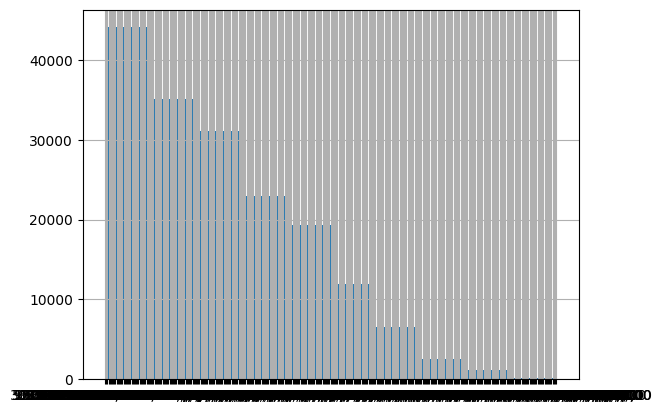

In [17]:
train_df['Tenure_Age'].hist()

In [18]:
train_df['Exited'].value_counts()

Exited
0    138071
1     36957
Name: count, dtype: int64

In [116]:
train_df['EstimatedSalary']

0         181449.97
1           49503.5
2         184866.69
3          84560.88
4          15068.83
            ...    
175023     29179.52
175024    167773.55
175025     96270.64
175026    101699.77
175027     42085.58
Name: EstimatedSalary, Length: 175028, dtype: object

In [3]:
names = ['EstimatedSalary', 'Surname_tfidf_0', 'Surname_tfidf_1', 'Surname_tfidf_2', 'Surname_tfidf_3', 'Surname_tfidf_4', 'Tenure_Age', 'Bal_sal', 'Cred_Bal_Sal', 'Tenure']
for name in names:
    df[name] = df[name].apply(lambda x: float(str(x).replace('.','').replace(',','.')))
    train_df[name] = train_df[name].apply(lambda x: float(str(x).replace('.','').replace(',','.')))
    valid_df[name] = valid_df[name].apply(lambda x: float(str(x).replace('.','').replace(',','.')))
train_df.head()

,Number,Surname,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,...,France,Germany,Spain,Female,Male,Mem__no__Products,Cred_Bal_Sal,Bal_sal,Tenure_Age,Age_Tenure_product
0,0,2061,634.0,38.0,40.0,0.00,2.0,0,0,14553757.0,...,1,0,0,1,0,0.0,0.000000e+00,0.000000e+00,1.052632e+16,152.0
1,1,2100,602.0,52.0,10.0,0.00,2.0,1,1,6541338.0,...,1,0,0,1,0,2.0,0.000000e+00,0.000000e+00,1.923077e+16,52.0
2,2,1030,850.0,69.0,30.0,71467.33,2.0,1,1,14358625.0,...,0,1,0,1,0,2.0,4.230714e+15,4.977310e+16,4.347826e+16,207.0
3,3,1864,775.0,37.0,70.0,0.00,1.0,1,1,3825225.0,...,0,0,1,0,1,1.0,0.000000e+00,0.000000e+00,1.891892e+15,259.0
4,4,868,823.0,42.0,60.0,87637.28,1.0,0,1,19844691.0,...,1,0,0,1,0,1.0,3.634498e+16,4.416157e+15,1.428571e+16,252.0


In [50]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Surname,175028.0,1.617463e+03,8.138522e+02,0.000000e+00,9.490000e+02,1.666000e+03,2.292000e+03,2.931000e+03
CreditScore,175028.0,6.561131e+02,8.114827e+01,3.500000e+02,5.970000e+02,6.590000e+02,7.100000e+02,8.500000e+02
Age,175028.0,3.817134e+01,8.969565e+00,1.800000e+01,3.200000e+01,3.700000e+01,4.200000e+01,9.200000e+01
Tenure,175028.0,5.019968e+01,2.811155e+01,0.000000e+00,3.000000e+01,5.000000e+01,7.000000e+01,1.000000e+02
Balance,175028.0,5.667677e+04,6.298242e+04,0.000000e+00,0.000000e+00,0.000000e+00,1.207280e+05,2.508981e+05
NumOfProducts,175028.0,1.553072e+00,5.492118e-01,1.000000e+00,1.000000e+00,2.000000e+00,2.000000e+00,4.000000e+00
HasCrCard,175028.0,7.511827e-01,4.323290e-01,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
IsActiveMember,175028.0,4.987545e-01,4.999999e-01,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00
EstimatedSalary,175028.0,1.019598e+07,5.714430e+06,1.180000e+02,5.706171e+06,1.059860e+07,1.502424e+07,3.819017e+07
Exited,175028.0,2.111491e-01,4.081251e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00


In [4]:
names = ['Surname_tfidf_0', 'Surname_tfidf_1', 'Surname_tfidf_2', 'Surname_tfidf_3', 'Surname_tfidf_4', 'Tenure_Age', 'Bal_sal', 'Cred_Bal_Sal']
for name in names:
    df[name] = df[name] / np.max(train_df[name])
    train_df[name] = train_df[name] / np.max(train_df[name])
    valid_df[name] = train_df[name] / np.max(train_df[name])
train_df.head()

,Number,Surname,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,...,France,Germany,Spain,Female,Male,Mem__no__Products,Cred_Bal_Sal,Bal_sal,Tenure_Age,Age_Tenure_product
0,0,2061,634.0,38.0,40.0,0.00,2.0,0,0,14553757.0,...,1,0,0,1,0,0.0,0.000000,0.000000,0.171930,152.0
1,1,2100,602.0,52.0,10.0,0.00,2.0,1,1,6541338.0,...,1,0,0,1,0,2.0,0.000000,0.000000,0.314103,52.0
2,2,1030,850.0,69.0,30.0,71467.33,2.0,1,1,14358625.0,...,0,1,0,1,0,2.0,0.051974,0.627900,0.710145,207.0
3,3,1864,775.0,37.0,70.0,0.00,1.0,1,1,3825225.0,...,0,0,1,0,1,1.0,0.000000,0.000000,0.030901,259.0
4,4,868,823.0,42.0,60.0,87637.28,1.0,0,1,19844691.0,...,1,0,0,1,0,1.0,0.446498,0.055711,0.233333,252.0


In [5]:
# 'Surname_tfidf_1', 'Surname_tfidf_2', 'Surname_tfidf_3', 'Surname_tfidf_4', 'Tenure_Age', 'Bal_sal', 'Cred_Bal_Sal','France', 'Female','Surname_tfidf_0', 'Germany', 'Spain', 'Male', 'Age', 
values = df['Exited']
points = df.drop(['Exited', 'HasCrCard', 'Female', 'Tenure', 'Mem__no__Products',], axis=1)
# points = df.drop(['Exited'], axis=1)
train_points_origin, test_points_origin, train_valuess_origin, test_valuess_origin = train_test_split(points, values, test_size = 0.2)

train_points = train_df.drop(['Exited', 'HasCrCard', 'Female', 'Tenure', 'Mem__no__Products','Number'], axis=1)
train_values = train_df['Exited']

test_points = valid_df.drop(['Exited', 'HasCrCard', 'Female', 'Tenure', 'Mem__no__Products','Number'], axis=1)
test_values = valid_df['Exited']

In [67]:
train_points.head()

,Surname,CreditScore,Age,Balance,NumOfProducts,IsActiveMember,EstimatedSalary,Surname_tfidf_0,Surname_tfidf_1,Surname_tfidf_2,Surname_tfidf_3,Surname_tfidf_4,France,Germany,Spain,Male,Cred_Bal_Sal,Bal_sal,Tenure_Age,Age_Tenure_product
0,2061,634.0,38.0,0.00,2.0,0,14553757.0,4.473534e-01,-2.655438e-01,4.752233e-01,3.820252e-01,-1.070566e-01,1,0,0,0,0.000000,0.000000,0.171930,152.0
1,2100,602.0,52.0,0.00,2.0,1,6541338.0,-1.783059e-06,1.191769e-01,7.220859e-02,-2.321180e-01,1.657533e-01,1,0,0,0,0.000000,0.000000,0.314103,52.0
2,1030,850.0,69.0,71467.33,2.0,1,14358625.0,1.686140e-16,-8.253190e-15,-9.391074e-15,1.789192e-13,-9.320001e-13,0,1,0,0,0.051974,0.627900,0.710145,207.0
3,1864,775.0,37.0,0.00,1.0,1,3825225.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0,0,1,1,0.000000,0.000000,0.030901,259.0
4,868,823.0,42.0,87637.28,1.0,1,19844691.0,8.101572e-17,-4.682180e-14,1.791044e-14,-1.707603e-14,-1.993833e-15,1,0,0,0,0.446498,0.055711,0.233333,252.0


In [8]:
rf_model = ensemble.RandomForestClassifier(n_estimators=10)
rf_model.fit(train_points, train_values)
test_predict_rf = rf_model.predict(test_points)
accuracy = accuracy_score(test_values, test_predict_rf)
now = datetime.now()
print(accuracy)

0.8422556133234302


In [ ]:
filename = f'models/{accuracy}-RandomForest.sav'
with open(filename, 'wb') as f:
    pickle.dump(rf_model, f)

In [9]:
rf_model = pickle.load(open('models/0.8665371650574187-RandomForest.sav', 'rb'))
start = time()
test_predict_rf = rf_model.predict(test_points)
end = time()
print(f'{end - start:.3f}')
accuracy = accuracy_score(test_values, test_predict_rf)
print(accuracy)

0.094
0.8665371650574187


In [76]:
train_points.describe().T

,count,mean,std,min,25%,50%,75%,max
Surname,157525.0,1.617456e+03,8.140646e+02,0.000000,9.490000e+02,1.666000e+03,2.292000e+03,2931.00
CreditScore,157525.0,6.560571e+02,8.116425e+01,350.000000,5.970000e+02,6.590000e+02,7.100000e+02,850.00
Age,157525.0,3.817365e+01,8.974541e+00,18.000000,3.200000e+01,3.700000e+01,4.200000e+01,92.00
Balance,157525.0,5.666739e+04,6.300199e+04,0.000000,0.000000e+00,0.000000e+00,1.207279e+05,250898.09
NumOfProducts,157525.0,1.553265e+00,5.496497e-01,1.000000,1.000000e+00,2.000000e+00,2.000000e+00,4.00
IsActiveMember,157525.0,4.989684e-01,5.000005e-01,0.000000,0.000000e+00,0.000000e+00,1.000000e+00,1.00
EstimatedSalary,157525.0,1.019375e+07,5.710920e+06,118.000000,5.721346e+06,1.059692e+07,1.500484e+07,38190168.00
Surname_tfidf_0,157525.0,3.135259e-02,1.888660e-01,-0.851945,-9.891737e-09,0.000000e+00,4.093145e-08,1.00
Surname_tfidf_1,157525.0,-3.576596e-03,2.316236e-01,-1.126802,-7.503694e-08,0.000000e+00,7.963889e-08,1.00
Surname_tfidf_2,157525.0,-4.721665e-03,2.744815e-01,-1.700192,-1.570042e-07,0.000000e+00,1.266414e-07,1.00


In [86]:
columns = ['Balance', 'Surname', 'CreditScore', 'Age', 'EstimatedSalary', 'Age_Tenure_product']
for name in columns:
    train_points[f'Normalize{name}'] = train_points[name] / np.max(train_df[name])
    del train_points[name]
    
    test_points[f'Normalize{name}'] = test_points[name] / np.max(train_df[name])
    del test_points[name]
train_points.head()

,NumOfProducts,IsActiveMember,Surname_tfidf_0,Surname_tfidf_1,Surname_tfidf_2,Surname_tfidf_3,Surname_tfidf_4,France,Germany,Spain,Male,Cred_Bal_Sal,Bal_sal,Tenure_Age,NormalizeBalance,NormalizeSurname,NormalizeCreditScore,NormalizeAge,NormalizeEstimatedSalary,NormalizeAge_Tenure_product
0,2.0,0,4.473534e-01,-2.655438e-01,4.752233e-01,3.820252e-01,-1.070566e-01,1,0,0,0,0.000000,0.000000,0.171930,0.000000,0.703173,0.745882,0.413043,0.381086,0.172727
1,2.0,1,-1.783059e-06,1.191769e-01,7.220859e-02,-2.321180e-01,1.657533e-01,1,0,0,0,0.000000,0.000000,0.314103,0.000000,0.716479,0.708235,0.565217,0.171283,0.059091
2,2.0,1,1.686140e-16,-8.253190e-15,-9.391074e-15,1.789192e-13,-9.320001e-13,0,1,0,0,0.051974,0.627900,0.710145,0.284846,0.351416,1.000000,0.750000,0.375977,0.235227
3,1.0,1,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0,0,1,1,0.000000,0.000000,0.030901,0.000000,0.635960,0.911765,0.402174,0.100163,0.294318
4,1.0,1,8.101572e-17,-4.682180e-14,1.791044e-14,-1.707603e-14,-1.993833e-15,1,0,0,0,0.446498,0.055711,0.233333,0.349294,0.296145,0.968235,0.456522,0.519628,0.286364


In [87]:
columns = ['France', 'Germany', 'Spain', 'NormalizeAge_Tenure_product', 'Surname_tfidf_1']
for name in columns:
    del train_points[name]
    del test_points[name]

In [84]:
train_points.head()

,NumOfProducts,IsActiveMember,Surname_tfidf_0,Surname_tfidf_2,Surname_tfidf_3,Surname_tfidf_4,Male,Cred_Bal_Sal,Bal_sal,NormalizeBalance,NormalizeSurname,NormalizeCreditScore,NormalizeAge,NormalizeEstimatedSalary,NormalizeAge_Tenure_product
0,2.0,0,4.473534e-01,4.752233e-01,3.820252e-01,-1.070566e-01,0,0.000000,0.000000,0.000000,0.703173,0.745882,0.413043,0.381086,0.172727
1,2.0,1,-1.783059e-06,7.220859e-02,-2.321180e-01,1.657533e-01,0,0.000000,0.000000,0.000000,0.716479,0.708235,0.565217,0.171283,0.059091
2,2.0,1,1.686140e-16,-9.391074e-15,1.789192e-13,-9.320001e-13,0,0.051974,0.627900,0.284846,0.351416,1.000000,0.750000,0.375977,0.235227
3,1.0,1,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1,0.000000,0.000000,0.000000,0.635960,0.911765,0.402174,0.100163,0.294318
4,1.0,1,8.101572e-17,1.791044e-14,-1.707603e-14,-1.993833e-15,0,0.446498,0.055711,0.349294,0.296145,0.968235,0.456522,0.519628,0.286364


In [52]:
print(max(test_points.count(axis='columns')))

11


In [90]:
count = max(train_points.count(axis='columns'))
model = models.Sequential()

model.add(layers.Dense(count, activation = "elu"))

model.add(layers.Dense(count * 2, activation = "relu"))

model.add(layers.Dense(count, activation = "relu"))

model.add(layers.Dense(1, activation = "sigmoid"))

model.compile(
 optimizer = "adam",
 loss = "binary_crossentropy",
 metrics = ["accuracy"]
)
results = model.fit(
 train_points, train_values,
 epochs= 11,
 batch_size = 100,
 validation_data = (test_points, test_values)
)
print("Test-Accuracy:", np.max(results.history["accuracy"]))

Epoch 1/11
1576/1576 [==============================] - 2s 777us/step - loss: 0.3990 - accuracy: 0.8235 - val_loss: 0.3529 - val_accuracy: 0.8472
Epoch 2/11
1576/1576 [==============================] - 1s 720us/step - loss: 0.3521 - accuracy: 0.8488 - val_loss: 0.3456 - val_accuracy: 0.8495
Epoch 3/11
1576/1576 [==============================] - 1s 728us/step - loss: 0.3488 - accuracy: 0.8496 - val_loss: 0.3440 - val_accuracy: 0.8498
Epoch 4/11
1576/1576 [==============================] - 1s 724us/step - loss: 0.3472 - accuracy: 0.8505 - val_loss: 0.3421 - val_accuracy: 0.8512
Epoch 5/11
1576/1576 [==============================] - 1s 719us/step - loss: 0.3458 - accuracy: 0.8512 - val_loss: 0.3411 - val_accuracy: 0.8514
Epoch 6/11
1576/1576 [==============================] - 1s 747us/step - loss: 0.3447 - accuracy: 0.8517 - val_loss: 0.3420 - val_accuracy: 0.8513
Epoch 7/11
1576/1576 [==============================] - 1s 728us/step - loss: 0.3440 - accuracy: 0.8528 - val_loss: 0.3425 -

In [82]:
loss, acc = model.evaluate(test_points, test_values)

547/547 [==============================] - 0s 519us/step - loss: 0.3366 - accuracy: 0.8552


In [41]:
accuracy = np.max(results.history["accuracy"])
filename = f'models/{accuracy}-NN.keras'
model.save(filename)

In [91]:
model = saving.load_model('models/0.8641231656074524-NN.keras')
loss, acc = model.evaluate(test_points, test_values)

547/547 [==============================] - 0s 508us/step - loss: 0.6504 - accuracy: 0.6465


In [11]:
accuracy = 86.65
time = 0.094
total=(1.25 * (accuracy / 100) * ((5-time)/5 if time<5 else 0))/(0.25 * (accuracy / 100) + ((5-time)/5 if time<5 else 0))
print(total)

0.887243336881431
